#### Create another data cube in the style recommended by Sebastian

Create another cube with error mechanism prediction from mechtest(s) instead of the cv scores and scenario number

Do the plots like the regression scores from earlier

In [16]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [17]:
# Function definitions & Mics code
def read_in_data_cube(base_path: str = "../data", filename: str = "auc_roc_tensors_dict.npz") -> dict[str:np.ndarray]:
    """Read in the numpy array given a base path, the dataset_id, and the error_rate."""
    path = os.path.join(base_path, filename)
    return np.load(path, allow_pickle=True)


def decide_error_mech(case_1: np.ndarray, case_2: np.ndarray, case_3: np.ndarray, alpha: float = 0.05) -> str:
    """Predict the error mechanism using the mech detect as described below.
    
    Description:
        - Two step test that does the following sub-tests:
            1. Test complete scores vs. shuffled scores using H_0: complete <= shuffled, H_A: complete > shuffled
            2. Test complete scores vs. missing scores using H_0: complete <= missing, H_A: complete > missing
        - The resulting decision is decided as follows:
            1. If we reject H_0 -> step 2. If we fail to reject H_0 -> ECAR
            2*. If we reject H_0 -> ENAR. If we fail to reject H_0 -> EAR
            * Step 2 is only performed if necessary
    
    Inputs:
        - case_1 (np.ndarray): The performance of a model trained to predict the error mask of a given column using all input data. (aka Complete Task)
        - case_2 (np.ndarray): The performance of a model trained to predict the randomly permuted error mask of a given column using all input data. (aka Shuffled Task)
        - case_3 (np.ndarray): The performance of a model trained to predict the error mask of a given column using all data except that column. (aka Missing Task)
        - alpha (float, optional): The significance level of the test. Defaults to 0.05.
    
    Return:
        - A string, one of: "ECAR", "EAR", "ENAR"        
    """
    
    result: str

    # Sub-Test 1 - H_0: case_1 <= case_2, H_A: case_1 > case_2
    w_stat_1, p_value_1 = stats.mannwhitneyu(case_1, case_2, alternative='greater')

    if p_value_1 < alpha/2:  # Reject H_0 - evidence against ECAR
        # Sub-Test 2 - H_0: case_1 <= case_3, H_A: case_1 > case_3
        w_stat_2, p_value_2 = stats.mannwhitneyu(case_1, case_3, alternative='greater')

        if p_value_2 < alpha/2:  # Reject H_0 - evidence against ECAR and EAR
            result = "ENAR"
        else:  # Fail to reject H_0 - no evidence against EAR
            result = "EAR"

    else:  # Fail to reject H_0 - no evidence against ECAR
        result = "ECAR"

    return result


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


# Misc plotting code
missingness_mechanisms_for_plotting = ["MCAR", "MAR", "MNAR"]  # Ordering is important!

In [18]:
# Read in data_cube
data_dict = read_in_data_cube()
dataset_ids = data_dict.files
dataset_ids

['1046',
 '1049',
 '1050',
 '1063',
 '1067',
 '1068',
 '1461',
 '1464',
 '1480',
 '1494',
 '151',
 '1510',
 '23',
 '23517',
 '251',
 '31',
 '310',
 '37',
 '40701',
 '40975',
 '40994',
 '4135',
 '42493',
 '44',
 '44025',
 '44026',
 '44054',
 '44055',
 '44056',
 '44059',
 '44061',
 '44062',
 '44063',
 '44064',
 '44066',
 '44089',
 '44090',
 '44091',
 '44120',
 '44122',
 '44123',
 '44124',
 '44125',
 '44126',
 '44127',
 '44130',
 '44131',
 '44132',
 '44133',
 '44134',
 '44136',
 '44137',
 '44138',
 '44139',
 '44140',
 '44141',
 '44142',
 '44144',
 '44145',
 '44147',
 '44148',
 '44156',
 '44157',
 '44158',
 '44160',
 '44162',
 '44956',
 '44957',
 '44958',
 '44959',
 '44960',
 '44962',
 '44963',
 '44964',
 '44966',
 '44967',
 '44969',
 '44970',
 '44971',
 '44972',
 '44974',
 '44976',
 '44977',
 '44978',
 '44979',
 '44980',
 '44981',
 '44983',
 '44984',
 '44987',
 '44989',
 '44990',
 '44993',
 '44994',
 '45012',
 '4534',
 '45402',
 '54',
 '6',
 '725',
 '823']

In [19]:
# Do the tests, accumulate results, write the cube!
processed_data = {}


for dataset_id in data_dict.files:
    tensor = data_dict[dataset_id]  # Shape (5, 3, n_cols, 2, 4, 10)
    
    # Create a new array to hold strings, same shape but last two dims flattened to one string
    result = np.empty(tensor.shape[:4], dtype=object)  # (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(tensor.shape[0]):  # Error rate
        for j in range(tensor.shape[1]):  # Error mechanism
            for k in range(tensor.shape[2]):  # Column
                for l in range(tensor.shape[3]):  # Clean/Dirty
                        one_instance = tensor[i,j,k,l]

                        # Perform tests, save results    
                        result[i,j,k,l] = decide_error_mech(one_instance[0], one_instance[1], one_instance[2])

    processed_data[dataset_id] = result
    
#  np.savez_compressed('../data/test_results_datacube.npz', **processed_data)  # Checkpoint'd

In [20]:
# Sanity check - 17 columns in dataset 6

assert processed_data['6'].shape == (5, 3, 17, 2)

In [21]:
# Analysis setup
error_mechanisms = ["ECAR", "EAR", "ENAR"]  # Ordering is important!
error_rates = ["0.1", "0.25", "0.5", "0.75", "0.9"]  # Ordering is important!

CLEAN = 0
DIRTY = 1

### Test Hit/Miss


In [22]:
boolean_tensors = {}

for dataset_id in data_dict.files:
    tensor = processed_data[dataset_id]  # Shape (5, 3, n_cols, 2, 4, 10)
    
    # Create a new array to hold strings, same shape but last two dims flattened to one string
    result = np.empty(tensor.shape[:4], dtype=object)  # (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(tensor.shape[0]):  # Error rate
        for j in range(tensor.shape[1]):  # Error mechanism
            for k in range(tensor.shape[2]):  # Column
                for l in range(tensor.shape[3]):  # Clean/Dirty
                    
                    if tensor[i,j,k,l] == error_mechanisms[j]:
                        result[i,j,k,l] = True
                    else:
                        result[i,j,k,l] = False
                    
    boolean_tensors[dataset_id] = result

#  np.savez_compressed('./data/test_results_datacube_boolean.npz', **boolean_tensors)  # Checkpoint'd

### Graphical analysis - Clean

In [23]:
# Compile accuracies
clean_results = np.empty((5, 3, len(data_dict.files), 2))  # (5, 3, n_datasets, 2)

# Iterate over all datasets
for dataset_index, dataset_id in enumerate(data_dict.files):
    one_cube = boolean_tensors[dataset_id]  # Shape (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(one_cube.shape[0]):  # Error rate
        for j in range(one_cube.shape[1]):  # Error mechanism
            md_slice = one_cube[i,j,:,CLEAN]
            
            md_accuracy = np.mean(md_slice)
            
            clean_results[i, j, dataset_index] = md_accuracy

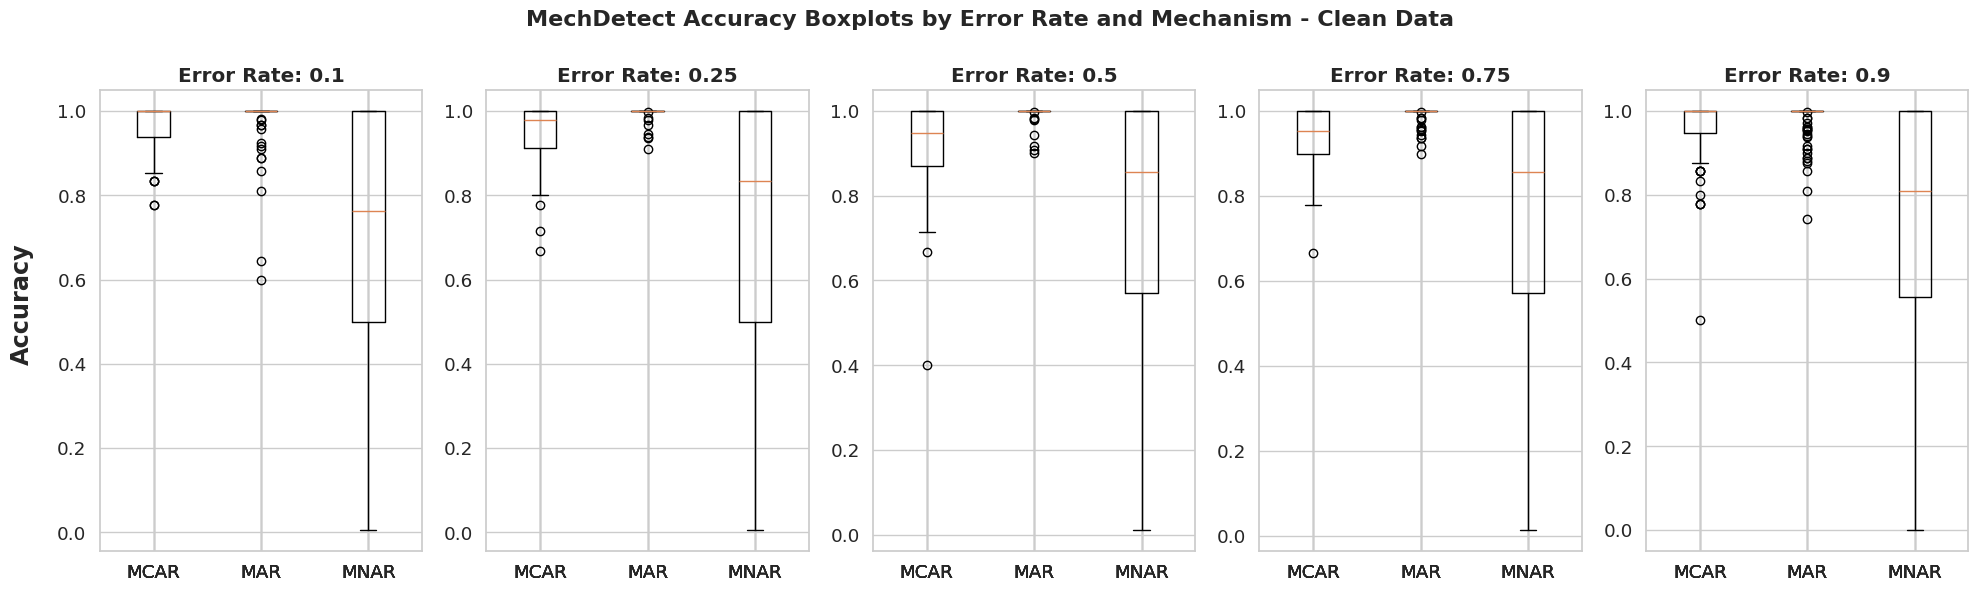

Accuracy on clean data: 0.8914


In [28]:
# Mech detect accuracy over various error rates
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharex=True)
accuracy_clean_data = []
for i, ax in enumerate(axes):
    # Collect data for each mechanism across datasets
    box_data = [clean_results[i,j,:,1] for j in range(3)]
    accuracy_clean_data.extend(box_data)
    ax.boxplot(box_data, tick_labels=missingness_mechanisms_for_plotting)
    ax.set_title(f"Error Rate: {error_rates[i]}", fontweight='bold')
    ax.grid(True)
    
fig.suptitle("MechDetect Accuracy Boxplots by Error Rate and Mechanism - Clean Data", fontsize=16, fontweight='bold', y=0.99)
fig.supylabel("Accuracy", fontweight='bold', x=0.01)
plt.tight_layout(rect=[0, 0, 1, 1])  # leaves space at the top for suptitle
fig.savefig("../plots/mechdetect_accuracy_clean_boxplots.pdf", format="pdf", bbox_inches="tight")
plt.show()

print(f"Accuracy on clean data: {np.array(accuracy_clean_data).mean():.4f}")

### Graphical Analysis - Dirty

In [29]:
# Compile accuracies
dirty_results = np.empty((5, 3, len(data_dict.files), 2))  # (5, 3, n_datasets, 2)

# Iterate over all datasets
for dataset_index, dataset_id in enumerate(data_dict.files):
    one_cube = boolean_tensors[dataset_id]  # Shape (5, 3, n_cols, 2)
    
    # Tensor iteration
    for i in range(one_cube.shape[0]):  # Error rate
        for j in range(one_cube.shape[1]):  # Error mechanism
            md_slice = one_cube[i,j,:,DIRTY]
            
            md_accuracy = np.mean(md_slice)
            
            dirty_results[i, j, dataset_index] = md_accuracy

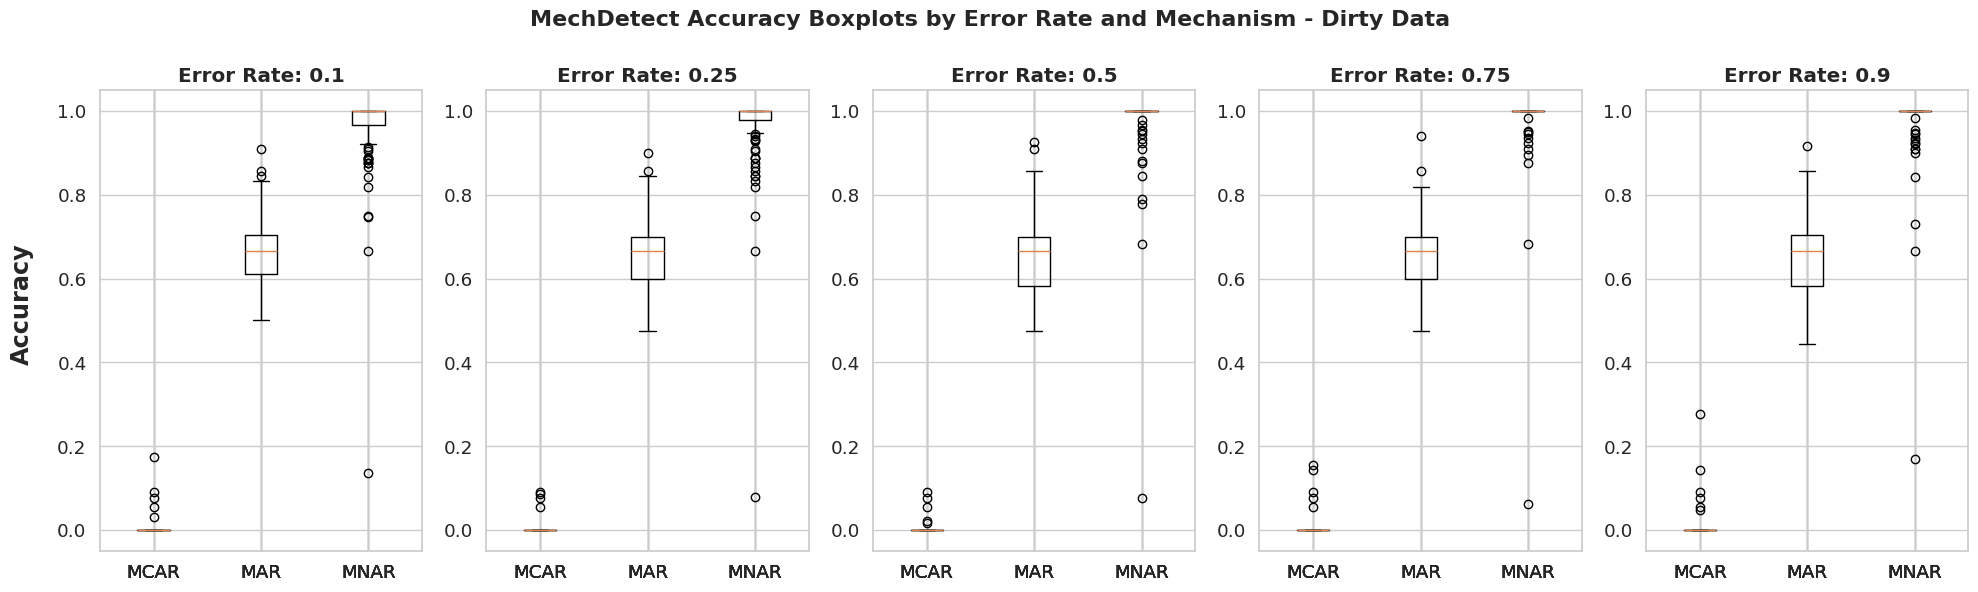

Dirty data accuracy over all datasets: 0.5438


In [30]:
# Plot MechDetect results — Dirty Data
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharex=True)
accuracy_dirty_data = []
for i, ax in enumerate(axes):
    # Collect data for each mechanism across datasets
    box_data = [dirty_results[i, j, :, 1] for j in range(3)]
    accuracy_dirty_data.extend(box_data)

    ax.boxplot(box_data, tick_labels=missingness_mechanisms_for_plotting)
    ax.set_title(f"Error Rate: {error_rates[i]}", fontweight='bold')
    ax.grid(True)

fig.suptitle("MechDetect Accuracy Boxplots by Error Rate and Mechanism - Dirty Data", 
             fontsize=16, fontweight='bold', y=0.99)
fig.supylabel("Accuracy", fontweight='bold', x=0.01)
plt.tight_layout(rect=[0, 0, 1, 1])  # leaves space at the top for suptitle

# Save to PDF
fig.savefig("../plots/mechdetect_accuracy_dirty_boxplots.pdf", format="pdf", bbox_inches="tight")

plt.show()

print(f"Dirty data accuracy over all datasets: {np.array(accuracy_dirty_data).mean():.4f}")

### Side-by-side - Error Rate: 0.5

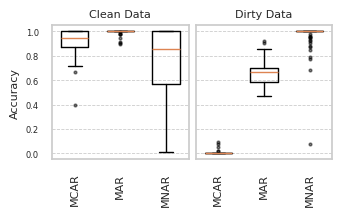

In [31]:
# Match seaborn style
sns.set_theme(style="whitegrid", font_scale=1.2)
flierprops = dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none', alpha=0.5)

error_index = 2  # Error rate = 0.5

# Prepare boxplot data
box_data_clean = [clean_results[error_index, j, :, 1] for j in range(3)]
box_data_dirty = [dirty_results[error_index, j, :, 1] for j in range(3)]

# Create 1 row, 2 column subplot
fig, axes = plt.subplots(ncols=2, figsize=set_size(241.14749), sharey=True)  # Full textwidth: 506.295 # columnwidth: 241.14749

# Plot 1: Clean data
positions = np.arange(1, len(box_data_clean) + 1)
axes[0].boxplot(box_data_clean, positions=positions, flierprops=flierprops, widths=0.6)
axes[0].set_title("Clean Data", fontsize=8)
axes[0].set_xticklabels(
    missingness_mechanisms_for_plotting,
    rotation=90,
    ha='center',
    fontsize=8
)
axes[0].set_ylabel("Accuracy", fontsize=8, x=-0.12)
axes[0].grid(axis='y', linestyle='--', linewidth=0.6)
axes[0].grid(axis='x', visible=False)

# Plot 2: Dirty data
positions = np.arange(1, len(box_data_dirty) + 1)
axes[1].boxplot(box_data_dirty, positions=positions, flierprops=flierprops, widths=0.6)
axes[1].set_title("Dirty Data", fontsize=8)
axes[1].set_xticklabels(
    missingness_mechanisms_for_plotting,
    rotation=90,
    ha='center',
    fontsize=8
)
axes[1].grid(axis='y', linestyle='--', linewidth=0.6)
axes[1].grid(axis='x', visible=False)

# Shrink y-labels
axes[0].tick_params(axis='y', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)

# Adjust layout
plt.subplots_adjust(
    left=0.14,   # Reduce left margin
    right=0.98,  # Reduce right margin
    bottom=0.25, # Reduce bottom (x-tick label spacing)
    top=0.9,     # Leave a bit of space if there's a suptitle
    wspace=0.05   # Reduce inter-subplot horizontal space
)

# Save combined figure
fig.savefig("../plots/mechdetect_accuracy_0.5_side_by_side.pdf", format="pdf")
plt.show()